In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score
from scipy.ndimage.filters import gaussian_filter1d, uniform_filter1d, median_filter
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style("darkgrid")

#Import libraries for Deep Learning
from keras.models import Sequential, Model
from keras.layers import Conv1D, LSTM, MaxPool1D, Dense, Dropout, Flatten, BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

print ('Libraries Loaded!')

Using TensorFlow backend.


Libraries Loaded!


In [2]:
#Created a function to remove noise from data with fourier transformation

def fourier(data):
    datafft= np.zeros(data.shape)
    for row in range(data.shape[0]):
        #fft
        fou=np.fft.fft(data[row])
        f1,f2= 0, 0
        fr=np.fft.fftfreq(3197,0.01)
        #make up a narrow bandpass with a Gaussian
        df=0.1
        gpl= np.exp(- ((fr-f1)/(2*df))**2)+ np.exp(- ((fr-f2)/(2*df))**2)  # pos. frequencies
        gmn= np.exp(- ((fr+f1)/(2*df))**2)+ np.exp(- ((fr+f2)/(2*df))**2)  # neg. frequencies
        g=gpl+gmn    
        filt=fou*g  #filtered spectrum = spectrum * bandpass 
        #ifft
        s2=np.fft.ifft(filt)
        datafft[row]= s2
    return (datafft)

# Load Dataset
The data is Loaded and the LABELS is converted from (1,2) to (0,1) for conviniency.

In [3]:
data1 = pd.read_csv('ExoTrain.csv')
Y1 = data1['LABEL'].values - 1
X = data1.drop('LABEL', axis=1).values
Y = Y1[:,np.newaxis]

In [5]:
# x_test_1 = data2[data2['LABEL']==1]
# x_test_2 = data2[data2['LABEL']==2]
# x_test_2_= x_test_2.drop('LABEL', axis=1).values
# for i in range(9):
#     roll_state = np.random.randint(x_test_2_.shape[1])
#     x_test_2_ = np.vstack((x_test_2_, np.roll(x_test_2_[i], roll_state, axis = 0)))
# x_test_2_ = pd.DataFrame(x_test_2_)
# x_test_2_.columns = x_test_1.columns[1:]
# x_test_2_['LABEL'] = 2
# newdata = x_test_2_.append(x_test_1)

# newdata.fillna(2, inplace=True)
# newdata.reset_index(drop=True, inplace=True)
# newdata = newdata.reindex_axis(x_test_1.columns, axis=1)
# newdata.to_csv('testing.csv', index=False)

# Data Visualisation

Label= 1 
First Column-      Original
Second Column-     Rolling Mean
Third Column-      Median Filter
Fourth Column-     Uniform Filter
Fifth Column-      Fourier Filter 


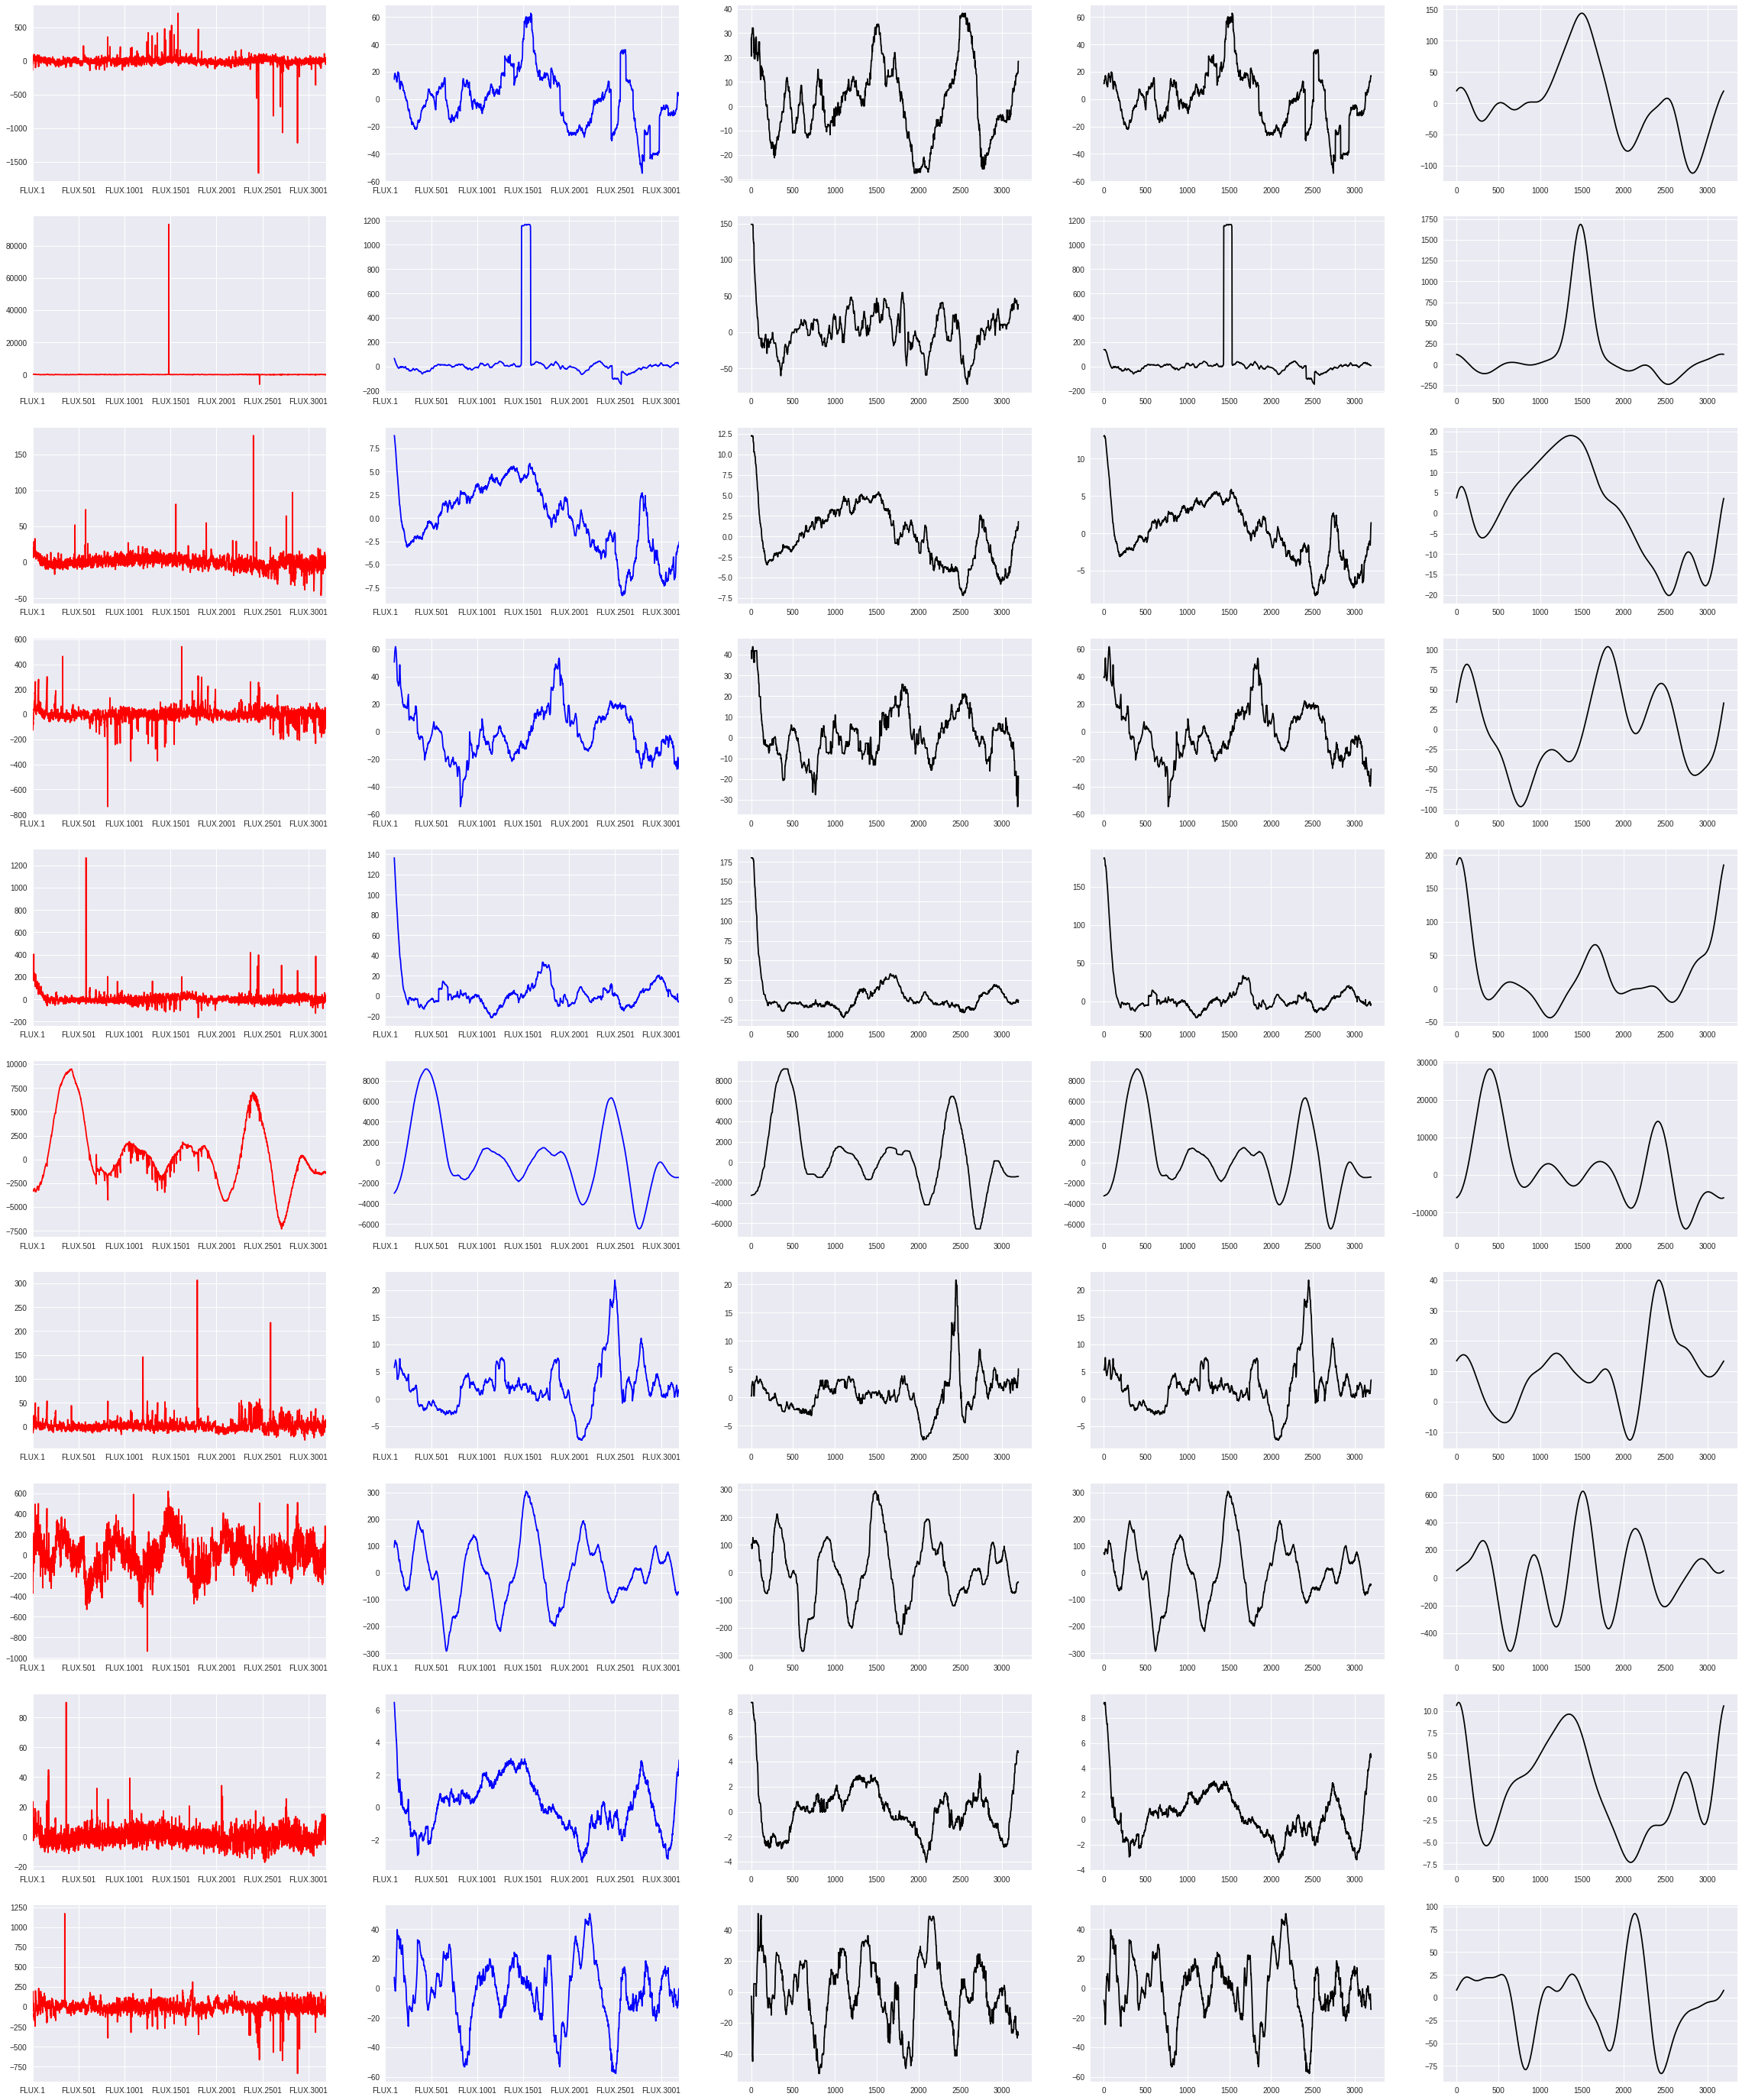

In [4]:
label= 1             # Here label i is exoplanet and 0 is non-planet
num_row=10           # Number of rows to plot
col_plot=5           # 5 plots in a row
j=1
train= data1          # plots from training data

print ('Label=', label,'\n\
First Column-      Original\n\
Second Column-     Rolling Mean\n\
Third Column-      Median Filter\n\
Fourth Column-     Uniform Filter\n\
Fifth Column-      Fourier Filter ')
fig = plt.figure(figsize=(8*col_plot, num_row*5))
for i in range(num_row):
    
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new1= train[train.LABEL==label].iloc[i, :].drop('LABEL')
    new1.plot(color= 'red', label= 'new1')
   
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new2= pd.rolling_mean( train[train.LABEL==label].iloc[i, :].drop('LABEL'), window= 100)
    new2.plot(color= 'blue', label= 'new2')
   
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new3=median_filter(train[train.LABEL==label].iloc[i, :].drop('LABEL'), size=100)
    plt.plot(new3, color= 'black', label= 'new3')
    
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new4= uniform_filter1d(train[train.LABEL==label].iloc[i, :].drop('LABEL'), size=100)
    plt.plot(new4, color= 'black', label= 'new4')
    
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new5= fourier(train[train.LABEL==label].iloc[i, :].drop('LABEL').values[np.newaxis, :])
    plt.plot(new5[0], color= 'black', label= 'new5')


# Split data for training and testing

In [5]:
# simple cross-validation.(k-fold cross validation not used because of lot of time being taken for training k*timenow)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=531, stratify=Y)

# Data preprocessing 

In [6]:
#Scale each observation to zero mean and unit variance.
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [7]:
#Noise in the data can be ignored by adding a gaussian filter
#This could more elegantly be done as an extra layer with fixed weights.
x_train1 = np.stack([x_train, gaussian_filter1d(x_train, 1, axis=1)], axis=2)
x_test1 = np.stack([x_test, gaussian_filter1d(x_test, 1, axis=1)], axis=2)

In [8]:
x_train2 = np.stack([x_train, fourier(x_train)], axis=2)
x_test2 = np.stack([x_test, fourier(x_test)], axis=2)

In [9]:
x_train3 = x_train[:,:,np.newaxis]
x_test3 = x_test[:,:,np.newaxis]

In [10]:
print ('Shape of x_train1', x_train1.shape)
print ('Shape of x_test1', x_test1.shape)
print("*"*40)
print ('Shape of x_train2', x_train2.shape)
print ('Shape of x_test2', x_test2.shape)
print("*"*40)
print ('Shape of x_train3', x_train3.shape)
print ('Shape of x_test3', x_test3.shape)

Shape of x_train1 (3564, 3197, 2)
Shape of x_test1 (396, 3197, 2)
****************************************
Shape of x_train2 (3564, 3197, 2)
Shape of x_test2 (396, 3197, 2)
****************************************
Shape of x_train3 (3564, 3197, 1)
Shape of x_test3 (396, 3197, 1)


# Model Architecture

In [11]:
# 1-D convolutions are frequently used to learn sequential patterns
model1 = Sequential()
model1.add(Conv1D(filters=16, kernel_size=11, activation='relu', input_shape=x_train1.shape[1:]))
model1.add(MaxPool1D(strides=4))
model1.add(BatchNormalization())
model1.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model1.add(MaxPool1D(strides=4))
model1.add(BatchNormalization())
model1.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model1.add(MaxPool1D(strides=4))
model1.add(BatchNormalization())
model1.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model1.add(MaxPool1D(strides=4))
model1.add(Flatten())
model1.add(Dropout(0.3))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid'))

In [12]:
# 1-D convolutions are frequently used to learn sequential patterns
model2 = Sequential()
model2.add(Conv1D(filters=24, kernel_size=11, activation='relu', input_shape=x_train2.shape[1:]))
model2.add(MaxPool1D(strides=4))
model2.add(BatchNormalization())
model2.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model2.add(MaxPool1D(strides=4))
model2.add(BatchNormalization())
model2.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model2.add(MaxPool1D(strides=4))
model2.add(BatchNormalization())
model2.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model2.add(MaxPool1D(strides=4))
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(1, activation='sigmoid'))

In [13]:
model3 = Sequential()
model3.add(Conv1D(filters=16, kernel_size=11, activation='relu', input_shape=x_train3.shape[1:]))
model3.add(MaxPool1D(strides=4))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model3.add(MaxPool1D(strides=4))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model3.add(MaxPool1D(strides=4))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model3.add(MaxPool1D(strides=4))
model3.add(LSTM(10))
model3.add(Dense(1, activation='sigmoid'))

In [14]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3187, 16)          368       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 797, 16)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 797, 16)           64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 787, 64)           11328     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 197, 64)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 197, 64)           256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 187, 32)           22560     
__________

In [15]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 3187, 24)          552       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 797, 24)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 797, 24)           96        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 791, 64)           10816     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 198, 64)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 198, 64)           256       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 188, 64)           45120     
__________

In [16]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 3187, 16)          192       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 797, 16)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 797, 16)           64        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 787, 64)           11328     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 197, 64)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 197, 64)           256       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 187, 32)           22560     
__________

# Data Augmentation

In [20]:
# feeding training data to the model in batches
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = 16
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    planet = np.where(y_train[:,0] == 1.)[0]
    non_planet = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(planet)
        np.random.shuffle(non_planet)
    
        x_batch[:half_batch] = x_train[planet[:half_batch]]
        x_batch[half_batch:] = x_train[non_planet[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[planet[:half_batch]]
        y_batch[half_batch:] = y_train[non_planet[half_batch:batch_size]]
    
        for i in range(batch_size):
            roll_state = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], roll_state, axis = 0)
     
        yield x_batch, y_batch

# Training the model

### Training at Learning Rate 4e-5 by Adam Optimiser

In [18]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1_history = model1.fit_generator(batch_generator(x_train1, y_train, 48), 
                    validation_data=(x_test1, y_test),
                    verbose=2, epochs=35,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/35
 - 19s - loss: 0.6875 - acc: 0.5691 - val_loss: 0.7768 - val_acc: 0.1439
Epoch 2/35
 - 15s - loss: 0.5546 - acc: 0.7131 - val_loss: 0.6487 - val_acc: 0.5707
Epoch 3/35
 - 15s - loss: 0.4480 - acc: 0.7836 - val_loss: 0.6530 - val_acc: 0.5253
Epoch 4/35
 - 15s - loss: 0.2560 - acc: 0.8982 - val_loss: 0.3072 - val_acc: 0.8485
Epoch 5/35
 - 15s - loss: 0.2059 - acc: 0.9271 - val_loss: 0.2860 - val_acc: 0.8838
Epoch 6/35
 - 15s - loss: 0.1114 - acc: 0.9574 - val_loss: 0.0967 - val_acc: 0.9697
Epoch 7/35
 - 15s - loss: 0.0969 - acc: 0.9673 - val_loss: 0.0686 - val_acc: 0.9823
Epoch 8/35
 - 15s - loss: 0.0869 - acc: 0.9716 - val_loss: 0.0726 - val_acc: 0.9722
Epoch 9/35
 - 15s - loss: 0.0991 - acc: 0.9706 - val_loss: 0.0590 - val_acc: 0.9672
Epoch 10/35
 - 15s - loss: 0.0936 - acc: 0.9740 - val_loss: 0.0962 - val_acc: 0.9495
Epoch 11/35
 - 16s - loss: 0.0413 - acc: 0.9910 - val_loss: 0.0442 - val_acc: 0.9874
Epoch 12/35
 - 16s - loss: 0.0412 - acc: 0.9886 - val_loss: 0.0260 - val_a

In [19]:
model1.compile(optimizer=Adam(0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])
model1_history2 = model1.fit_generator(batch_generator(x_train1, y_train, 48), 
                           validation_data=(x_test1, y_test), 
                           verbose=2, epochs=10,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/10
 - 29s - loss: 0.0084 - acc: 0.9978 - val_loss: 0.0174 - val_acc: 0.9949
Epoch 2/10
 - 26s - loss: 0.0189 - acc: 0.9972 - val_loss: 0.0069 - val_acc: 0.9975
Epoch 3/10
 - 26s - loss: 0.0072 - acc: 0.9984 - val_loss: 0.0052 - val_acc: 0.9975
Epoch 4/10
 - 24s - loss: 0.0077 - acc: 0.9991 - val_loss: 0.0100 - val_acc: 0.9975
Epoch 5/10
 - 26s - loss: 0.0060 - acc: 0.9978 - val_loss: 0.0089 - val_acc: 0.9975
Epoch 6/10
 - 25s - loss: 0.0070 - acc: 0.9987 - val_loss: 0.0127 - val_acc: 0.9975
Epoch 7/10
 - 28s - loss: 0.0090 - acc: 0.9981 - val_loss: 0.0088 - val_acc: 0.9975
Epoch 8/10
 - 28s - loss: 0.0151 - acc: 0.9978 - val_loss: 0.0051 - val_acc: 0.9975
Epoch 9/10
 - 29s - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0073 - val_acc: 0.9949
Epoch 10/10
 - 25s - loss: 0.0164 - acc: 0.9972 - val_loss: 0.0075 - val_acc: 0.9975


In [21]:
model1.compile(optimizer=Adam(0.00001), loss = 'binary_crossentropy', metrics=['accuracy'])
model1_history3 = model1.fit_generator(batch_generator(x_train1, y_train, 48), 
                    validation_data=(x_test1, y_test),
                    verbose=2, epochs=10,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/10
 - 26s - loss: 0.0531 - acc: 0.9886 - val_loss: 0.0153 - val_acc: 0.9975
Epoch 2/10
 - 27s - loss: 0.0334 - acc: 0.9908 - val_loss: 0.0270 - val_acc: 0.9899
Epoch 3/10
 - 28s - loss: 0.0290 - acc: 0.9931 - val_loss: 0.0324 - val_acc: 0.9899
Epoch 4/10
 - 27s - loss: 0.0294 - acc: 0.9940 - val_loss: 0.0323 - val_acc: 0.9924
Epoch 5/10
 - 27s - loss: 0.0268 - acc: 0.9937 - val_loss: 0.0313 - val_acc: 0.9924
Epoch 6/10
 - 26s - loss: 0.0174 - acc: 0.9968 - val_loss: 0.0302 - val_acc: 0.9924
Epoch 7/10
 - 26s - loss: 0.0171 - acc: 0.9959 - val_loss: 0.0276 - val_acc: 0.9924
Epoch 8/10
 - 26s - loss: 0.0245 - acc: 0.9965 - val_loss: 0.0264 - val_acc: 0.9924
Epoch 9/10
 - 26s - loss: 0.0106 - acc: 0.9959 - val_loss: 0.0265 - val_acc: 0.9924
Epoch 10/10
 - 27s - loss: 0.0201 - acc: 0.9953 - val_loss: 0.0247 - val_acc: 0.9924


In [23]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_history = model2.fit_generator(batch_generator(x_train2, y_train, 48), 
                    validation_data=(x_test2, y_test),
                    verbose=2, epochs=10,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/10
 - 58s - loss: 0.0417 - acc: 0.9857 - val_loss: 0.0191 - val_acc: 0.9949
Epoch 2/10
 - 62s - loss: 0.0406 - acc: 0.9878 - val_loss: 0.0309 - val_acc: 0.9949
Epoch 3/10
 - 55s - loss: 0.0591 - acc: 0.9823 - val_loss: 0.0629 - val_acc: 0.9722
Epoch 4/10
 - 54s - loss: 0.0315 - acc: 0.9905 - val_loss: 0.0321 - val_acc: 0.9848
Epoch 5/10
 - 59s - loss: 0.0142 - acc: 0.9954 - val_loss: 0.0382 - val_acc: 0.9848
Epoch 6/10
 - 62s - loss: 0.0205 - acc: 0.9937 - val_loss: 0.0434 - val_acc: 0.9949
Epoch 7/10
 - 58s - loss: 0.0225 - acc: 0.9943 - val_loss: 0.0624 - val_acc: 0.9899
Epoch 8/10
 - 55s - loss: 0.0255 - acc: 0.9931 - val_loss: 0.0272 - val_acc: 0.9924
Epoch 9/10
 - 52s - loss: 0.0164 - acc: 0.9952 - val_loss: 0.0276 - val_acc: 0.9949
Epoch 10/10
 - 51s - loss: 0.0161 - acc: 0.9954 - val_loss: 0.0645 - val_acc: 0.9798


In [24]:
model2.compile(optimizer=Adam(0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])
model2_history2 = model2.fit_generator(batch_generator(x_train2, y_train, 48), 
                           validation_data=(x_test2, y_test), 
                           verbose=2, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/5
 - 58s - loss: 0.0083 - acc: 0.9977 - val_loss: 0.0281 - val_acc: 0.9924
Epoch 2/5
 - 55s - loss: 0.0087 - acc: 0.9979 - val_loss: 0.0323 - val_acc: 0.9949
Epoch 3/5
 - 57s - loss: 0.0071 - acc: 0.9985 - val_loss: 0.0300 - val_acc: 0.9949
Epoch 4/5
 - 68s - loss: 0.0102 - acc: 0.9977 - val_loss: 0.0509 - val_acc: 0.9949
Epoch 5/5
 - 62s - loss: 0.0097 - acc: 0.9987 - val_loss: 0.0394 - val_acc: 0.9924


In [25]:
model2.compile(optimizer=Adam(0.00001), loss = 'binary_crossentropy', metrics=['accuracy'])
model2_history3 = model2.fit_generator(batch_generator(x_train2, y_train, 48), 
                    validation_data=(x_test2, y_test),
                    verbose=2, epochs=5,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/5
 - 62s - loss: 0.0066 - acc: 0.9981 - val_loss: 0.0412 - val_acc: 0.9924
Epoch 2/5
 - 62s - loss: 0.0037 - acc: 0.9987 - val_loss: 0.0419 - val_acc: 0.9924
Epoch 3/5
 - 59s - loss: 0.0031 - acc: 0.9989 - val_loss: 0.0435 - val_acc: 0.9949
Epoch 4/5
 - 54s - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0427 - val_acc: 0.9949
Epoch 5/5
 - 60s - loss: 0.0034 - acc: 0.9994 - val_loss: 0.0406 - val_acc: 0.9949


In [31]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_history = model3.fit_generator(batch_generator(x_train3, y_train, 48), 
                    validation_data=(x_test3, y_test),
                    verbose=2, epochs=35,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/10
 - 26s - loss: 0.6969 - acc: 0.6499 - val_loss: 0.1181 - val_acc: 0.9596
Epoch 2/10
 - 21s - loss: 0.4822 - acc: 0.7759 - val_loss: 0.2412 - val_acc: 0.8965
Epoch 3/10
 - 21s - loss: 0.2669 - acc: 0.9059 - val_loss: 0.3513 - val_acc: 0.8535
Epoch 4/10
 - 23s - loss: 0.1791 - acc: 0.9381 - val_loss: 1.1256 - val_acc: 0.5985
Epoch 5/10
 - 24s - loss: 0.1414 - acc: 0.9555 - val_loss: 0.4308 - val_acc: 0.8283
Epoch 6/10
 - 21s - loss: 0.1220 - acc: 0.9602 - val_loss: 0.5453 - val_acc: 0.8409
Epoch 7/10
 - 22s - loss: 0.1231 - acc: 0.9624 - val_loss: 0.4242 - val_acc: 0.8586
Epoch 8/10
 - 21s - loss: 0.1039 - acc: 0.9665 - val_loss: 0.1684 - val_acc: 0.9419
Epoch 9/10
 - 22s - loss: 0.0926 - acc: 0.9725 - val_loss: 0.2144 - val_acc: 0.9369
Epoch 10/10
 - 21s - loss: 0.0926 - acc: 0.9719 - val_loss: 0.2263 - val_acc: 0.9167


In [32]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_history2 = model3.fit_generator(batch_generator(x_train3, y_train, 48), 
                    validation_data=(x_test3, y_test),
                    verbose=2, epochs=10,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/5
 - 20s - loss: 0.1031 - acc: 0.9703 - val_loss: 0.1265 - val_acc: 0.9545
Epoch 2/5
 - 19s - loss: 0.0822 - acc: 0.9725 - val_loss: 0.2383 - val_acc: 0.9167
Epoch 3/5
 - 20s - loss: 0.0900 - acc: 0.9735 - val_loss: 0.0730 - val_acc: 0.9747
Epoch 4/5
 - 20s - loss: 0.0905 - acc: 0.9735 - val_loss: 0.2661 - val_acc: 0.8965
Epoch 5/5
 - 23s - loss: 0.0580 - acc: 0.9820 - val_loss: 0.1217 - val_acc: 0.9596


In [33]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_history3 = model3.fit_generator(batch_generator(x_train3, y_train, 32), 
                    validation_data=(x_test3, y_test),
                    verbose=2, epochs=5,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/5
 - 27s - loss: 0.0602 - acc: 0.9823 - val_loss: 0.0329 - val_acc: 0.9874
Epoch 2/5
 - 24s - loss: 0.0829 - acc: 0.9747 - val_loss: 0.0308 - val_acc: 0.9899
Epoch 3/5
 - 22s - loss: 0.0716 - acc: 0.9782 - val_loss: 0.0524 - val_acc: 0.9798
Epoch 4/5
 - 23s - loss: 0.0754 - acc: 0.9773 - val_loss: 0.0661 - val_acc: 0.9798
Epoch 5/5
 - 21s - loss: 0.0494 - acc: 0.9861 - val_loss: 0.0218 - val_acc: 0.9924


# Results Visulalisation

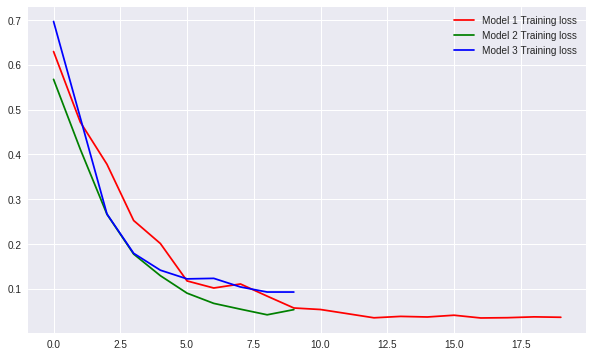

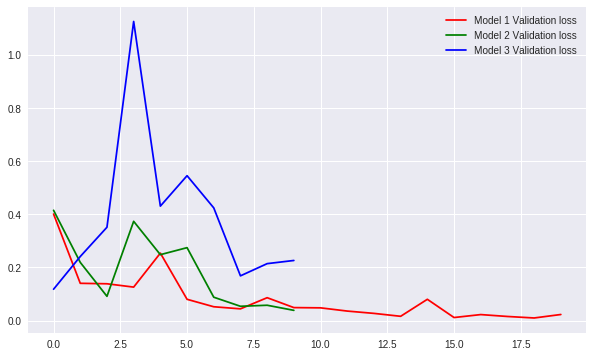

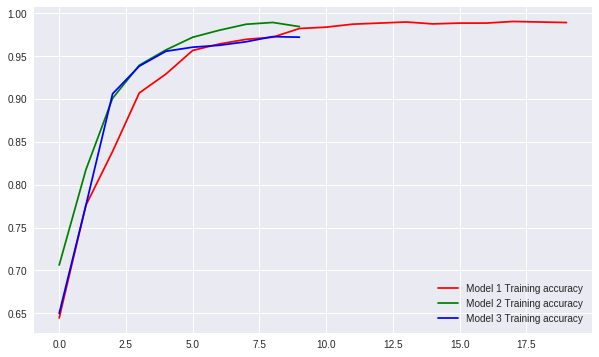

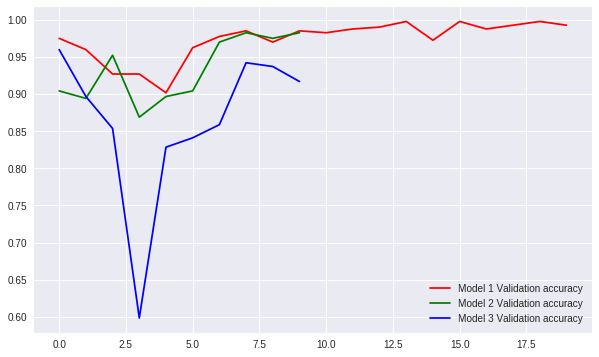

In [34]:
# plotting validation loss and accuracy
plt.figure(figsize=(10,6))
plt.plot(model1_history.history['loss'], color='r', label="Model 1 Training loss")
plt.plot(model2_history.history['loss'], color='g', label="Model 2 Training loss")
plt.plot(model3_history.history['loss'], color='b', label="Model 3 Training loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(model1_history.history['val_loss'], color='r', label="Model 1 Validation loss")
plt.plot(model2_history.history['val_loss'], color='g', label="Model 2 Validation loss")
plt.plot(model3_history.history['val_loss'], color='b', label="Model 3 Validation loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(model1_history.history['acc'], color='r', label="Model 1 Training accuracy")
plt.plot(model2_history.history['acc'], color='g', label="Model 2 Training accuracy")
plt.plot(model3_history.history['acc'], color='b', label="Model 3 Training accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(model1_history.history['val_acc'], color='r', label="Model 1 Validation accuracy")
plt.plot(model2_history.history['val_acc'], color='g', label="Model 2 Validation accuracy")
plt.plot(model3_history.history['val_acc'], color='b', label="Model 3 Validation accuracy")
plt.legend()
plt.show()


In [35]:
# obtaining the indexes of yes-exoplanet and no-exoplanet
no_exoplanet = np.where(y_test[:,0] == 0.)[0]
yes_exoplanet = np.where(y_test[:,0] == 1.)[0]

In [36]:
y_pred1 = model1.predict(x_test1)[:,0]

y_pred2 = model2.predict(x_test2)[:,0]

y_pred3 = model3.predict(x_test3)[:,0]


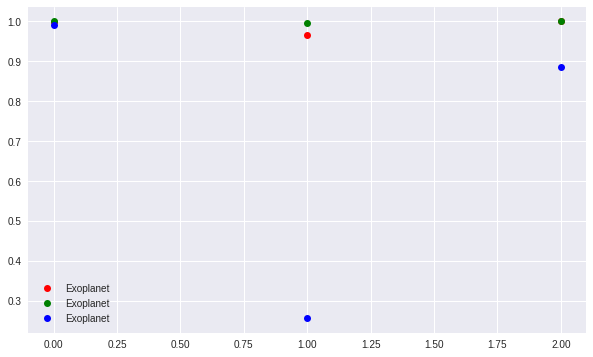

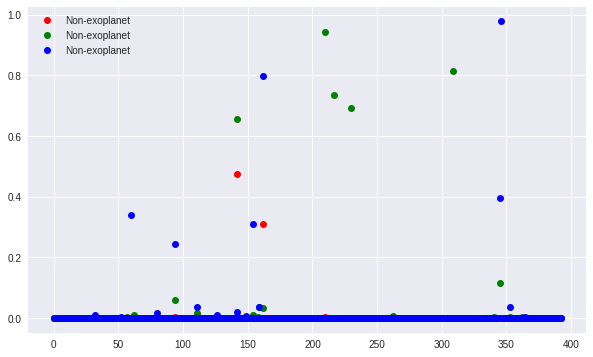

In [37]:
# plots indicating the model allotting different range of scores for different classes
# thus imploying the precision of the model
plt.figure(figsize=(10,6))
plt.plot([y_pred1[i] for i in yes_exoplanet], 'ro', label="Exoplanet")
plt.plot([y_pred2[i] for i in yes_exoplanet], 'go', label="Exoplanet")
plt.plot([y_pred3[i] for i in yes_exoplanet], 'bo', label="Exoplanet")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot([y_pred1[i] for i in no_exoplanet], 'ro', label="Non-exoplanet")
plt.plot([y_pred2[i] for i in no_exoplanet], 'go', label="Non-exoplanet")
plt.plot([y_pred3[i] for i in no_exoplanet], 'bo', label="Non-exoplanet")
plt.legend()
plt.show()

# Model 1 report

F1 score :  1.0
Threshold for F1 score :  0.505
****************************************
True skill score :  1.0
Threshold for True skill score :  0.505


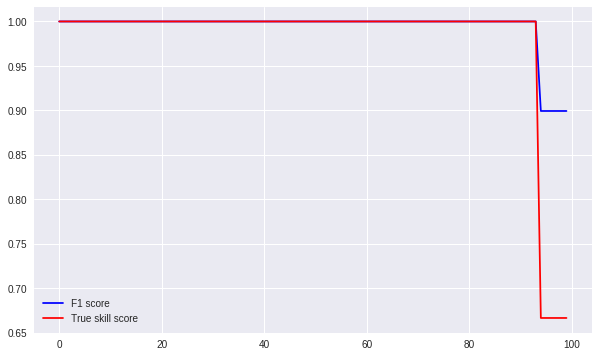

In [39]:
y_true = (y_test[:, 0] + 0.5).astype("int")
f1_score_= []
skill_score_= []

for i in (np.arange(0.5,1.0,.005)):
    y_pred_int= np.copy(y_pred1)
    y_pred_int[(y_pred_int>i)]=1
    y_pred_int[(y_pred_int<=i)]=0

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_int).ravel()

    skill_score_.append(((tp * tn) - (fp * fn)) / ((tp + fn) * (fp + tn)))
    f1_score_.append(f1_score(y_true, y_pred_int, average='macro'))



print("F1 score : ", np.max(f1_score_))
print("Threshold for F1 score : ", (np.min(np.where(f1_score_ == np.max(f1_score_)))+1)*0.005+0.5)
print("*"*40)
print("True skill score : ", np.max(skill_score_))
print("Threshold for True skill score : ", (np.min(np.where(skill_score_ == np.max(skill_score_)))+1)*0.005+0.5)

plt.figure(figsize=(10,6))
plt.plot(f1_score_, color='b', label="F1 score")
plt.plot(skill_score_, color='r', label="True skill score")
plt.legend()
plt.show()

# Model 2 report

F1 score :  1.0
Threshold for F1 score :  0.95
****************************************
True skill score :  1.0
Threshold for True skill score :  0.95


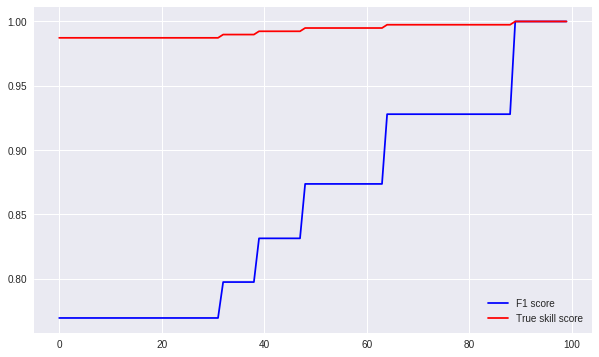

In [40]:
y_true = (y_test[:, 0] + 0.5).astype("int")
f1_score_= []
skill_score_= []

for i in (np.arange(0.5,1.0,.005)):
    y_pred_int= np.copy(y_pred2)
    y_pred_int[(y_pred_int>i)]=1
    y_pred_int[(y_pred_int<=i)]=0

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_int).ravel()

    skill_score_.append(((tp * tn) - (fp * fn)) / ((tp + fn) * (fp + tn)))
    f1_score_.append(f1_score(y_true, y_pred_int, average='macro'))



print("F1 score : ", np.max(f1_score_))
print("Threshold for F1 score : ", (np.min(np.where(f1_score_ == np.max(f1_score_)))+1)*0.005+0.5)
print("*"*40)
print("True skill score : ", np.max(skill_score_))
print("Threshold for True skill score : ", (np.min(np.where(skill_score_ == np.max(skill_score_)))+1)*0.005+0.5)

plt.figure(figsize=(10,6))
plt.plot(f1_score_, color='b', label="F1 score")
plt.plot(skill_score_, color='r', label="True skill score")
plt.legend()
plt.show()

# Model 3 report

F1 score :  0.832061068702
Threshold for F1 score :  0.805
****************************************
True skill score :  0.664122137405
Threshold for True skill score :  0.805


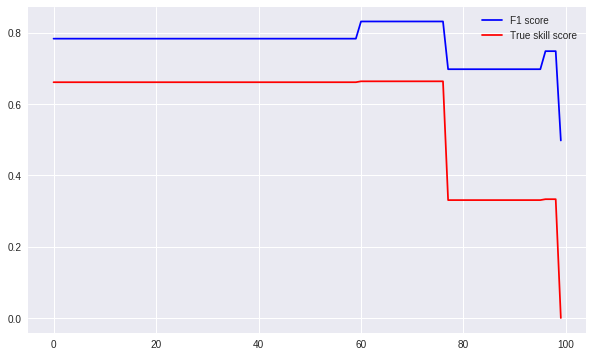

In [41]:
y_true = (y_test[:, 0] + 0.5).astype("int")
f1_score_= []
skill_score_= []

for i in (np.arange(0.5,1.0,.005)):
    y_pred_int= np.copy(y_pred3)
    y_pred_int[(y_pred_int>i)]=1
    y_pred_int[(y_pred_int<=i)]=0

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_int).ravel()

    skill_score_.append(((tp * tn) - (fp * fn)) / ((tp + fn) * (fp + tn)))
    f1_score_.append(f1_score(y_true, y_pred_int, average='macro'))



print("F1 score : ", np.max(f1_score_))
print("Threshold for F1 score : ", (np.min(np.where(f1_score_ == np.max(f1_score_)))+1)*0.005+0.5)
print("*"*40)
print("True skill score : ", np.max(skill_score_))
print("Threshold for True skill score : ", (np.min(np.where(skill_score_ == np.max(skill_score_)))+1)*0.005+0.5)

plt.figure(figsize=(10,6))
plt.plot(f1_score_, color='b', label="F1 score")
plt.plot(skill_score_, color='r', label="True skill score")
plt.legend()
plt.show()

# Evaluation by F1 Score

In [43]:
# f1_score with average macro because this is a highly imbalance class problem
for i in range(len(y_pred1)):
    if y_pred1[i]>0.505: # this value is obtained from the above plot
        y_pred1[i] = 1
    else:
        y_pred1[i] = 0
        
print(f1_score(y_true, y_pred1, average='macro'))

1.0


In [46]:
# the precision recall of each class is separately shown hence 
# removing the ambiguity of imbalanced classes..
from sklearn.metrics import classification_report
print("Model 1st report")
print(classification_report(y_true, y_pred1, target_names=['Explanet','Not Explanet']))
print("*"*80)
print("Model 2st report")
print(classification_report(y_true, y_pred2, target_names=['Explanet','Not Explanet']))
print("*"*80)
print("Model 3st report")
print(classification_report(y_true, y_pred3, target_names=['Explanet','Not Explanet']))

Model 1st report
              precision    recall  f1-score   support

    Explanet       1.00      1.00      1.00       393
Not Explanet       1.00      1.00      1.00         3

 avg / total       1.00      1.00      1.00       396

********************************************************************************
Model 2st report
              precision    recall  f1-score   support

    Explanet       1.00      1.00      1.00       393
Not Explanet       1.00      1.00      1.00         3

 avg / total       1.00      1.00      1.00       396

********************************************************************************
Model 3st report
              precision    recall  f1-score   support

    Explanet       1.00      1.00      1.00       393
Not Explanet       0.67      0.67      0.67         3

 avg / total       0.99      0.99      0.99       396

